In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import seaborn as sns

from datetime import datetime
saving_prefix = datetime.now().replace(microsecond=0).isoformat()
saving_prefix = str(Path('.') / "figs" / saving_prefix)
saving_prefix

'figs/2021-05-31T22:17:07'

In [2]:
results_dir = Path("/home/alexander/projects/car_data_analysis/results/ensemble")
runtimes = dict()
results = []

for exp_folder in tqdm(list(results_dir.glob("*[!.txt]"))):
    if exp_folder.is_dir():
        exp = exp_folder.stem
        for method_folder in exp_folder.glob("*"):
            method = method_folder.stem
            # One file per method
            for file in method_folder.glob("*.csv"):
                runtime = file.stem.split("_")[-1]
                this_results = pd.read_csv(file)
                this_results["method"] = method
                this_results["exp"] = exp
                if method in runtimes:
                    runtimes[method].append(runtime)
                else:
                    runtimes[method] = list(runtime)
                results.append(this_results)
    else:
        print(f"Ignoring {exp_folder}")

results = pd.concat(results)
datetime.now()

100%|██████████| 101/101 [00:12<00:00,  7.87it/s]


datetime.datetime(2021, 5, 31, 22, 17, 23, 753729)

In [3]:
results

,id,price,prediction,test,method,exp
0,0-1,750,1212.569167,0,RF,61
1,0-100,850,974.411300,0,RF,61
2,0-102,799,930.211167,0,RF,61
3,0-103,795,938.770967,0,RF,61
4,0-105,1000,1307.722667,0,RF,61
...,...,...,...,...,...,...
34826,49-143,3375,3801.443000,1,NN,82
34827,55-69,6995,7790.824700,1,NN,82
34828,55-256,6450,7176.462400,1,NN,82
34829,88-37,1995,1898.041100,1,NN,82


In [4]:
all_methods = ["CNN", "NLP", "NN", "LM", "GLM", "RF"]
included_methods = all_methods
# included_methods = ["NLP", "NN", "LM", "GLM", "RF"]
# included_methods = ["NLP", "RF"]
# included_methods = ["NN", "LM", "GLM", "RF"]
# included_methods = ["CNN", "NLP"]

overall = results
overall["exp"] = pd.to_numeric(overall["exp"])
overall = overall[overall["price"] < 11000] # Remove extremes for now (missed it earlier)
# Remove experiments that have missing methods
for defunct_exp in (0, 2, 8, 40, 44, 47, 59, 62,64,71, 80, 92,98):
    overall = overall[overall["exp"] != defunct_exp]
for excluded_method in [x for x in all_methods if x not in included_methods]:
    overall = overall[overall["method"] != excluded_method]
print(set(overall["method"]))
overall

{'GLM', 'CNN', 'RF', 'LM', 'NLP', 'NN'}


,id,price,prediction,test,method,exp
0,0-1,750,1212.569167,0,RF,61
1,0-100,850,974.411300,0,RF,61
2,0-102,799,930.211167,0,RF,61
3,0-103,795,938.770967,0,RF,61
4,0-105,1000,1307.722667,0,RF,61
...,...,...,...,...,...,...
34826,49-143,3375,3801.443000,1,NN,82
34827,55-69,6995,7790.824700,1,NN,82
34828,55-256,6450,7176.462400,1,NN,82
34829,88-37,1995,1898.041100,1,NN,82


In [5]:
# TODO: Think about how to free up memory

In [6]:
# For checking if all experiments in current set worked
grouped = overall.groupby(["id","exp"]).count()
{x[1] for x in grouped[grouped["method"] != len(included_methods)].index.values}

set()

In [7]:
# Some metrics
def _r_sq(y_true, y_pred):
    SST = sum((y_true-y_true.mean())**2)
    SSR = sum((y_true-y_pred)**2)
    return (1 - SSR/SST)

def _mse(y_true, y_pred):
    return sum((y_true - y_pred)**2)/len(y_pred)

def _mae(y_true, y_pred):
    return sum(abs(y_true - y_pred))/len(y_pred)

## Get weights of accuracy from training data only

In [8]:
train = overall[overall["test"] == 0]
test = overall[overall["test"] == 1]

In [9]:
# Aggregating id
grouped = train.groupby(["exp","method"])

# These are metrics per experiment per method
metrics = dict()
metrics["mae"] = grouped.apply(lambda x: _mae(x["price"], x["prediction"]) )
metrics["mae"]

exp  method
1    CNN       1936.132416
     GLM       1097.559783
     LM        1148.218321
     NLP       1339.327943
     NN        1002.413780
                  ...     
99   GLM       1085.003900
     LM        1145.854885
     NLP       1276.418102
     NN         980.173961
     RF         528.183742
Length: 522, dtype: float64

In [10]:
weights = dict()
max_alpha = 10e3
for metric in ["mae"]:
    for alpha in np.linspace(500, max_alpha, 10):
        tmp = metrics[metric].groupby("exp").transform(lambda x: alpha/x)
        # Softmax so weights sum to 1
        if metric not in weights:
            weights[metric] = dict()
        weights[metric][round(alpha)] = tmp.groupby("exp").transform(lambda x: np.exp(x)/sum(np.exp(x)))        

In [11]:
weights["mae"][max_alpha]

exp  method
1    CNN       0.000002
     GLM       0.000100
     LM        0.000067
     NLP       0.000019
     NN        0.000237
                 ...   
99   GLM       0.000060
     LM        0.000037
     NLP       0.000015
     NN        0.000162
     RF        0.999725
Length: 522, dtype: float64

In [12]:
# Quickly check that all weighting schemes have weights that sum to 1
for alpha in weights["mae"]:
    alpha_weights = weights["mae"][alpha]
    weight_sums = [sum(alpha_weights[exp]) for exp, _ in alpha_weights.index]
    results_close_to_one = np.allclose(weight_sums, 1.)
    print(f"{alpha} - {results_close_to_one}")

500 - True
1556 - True
2611 - True
3667 - True
4722 - True
5778 - True
6833 - True
7889 - True
8944 - True
10000 - True


## Ensembling

### Choose which metric we inversely get weights against

In [13]:
error_fn = _mae

### Joining weights onto train data to choose best $\alpha$

In [14]:
eval_data = train
w_weights = eval_data.copy()
w_weights["weighted_prediction"] = 0

In [15]:
mae_weighted = list()
for alpha, weights_per_exp in tqdm(weights["mae"].items()):
    # Join weights to correct experiment and method
    w_weights = pd.merge(eval_data, pd.DataFrame({"weight":weights_per_exp}), 
                                 how="left",
                                 left_on=["exp", "method"],
                                right_on=["exp", "method"])
    # Get weighted prediction
    w_weights["weighted_prediction"] = w_weights["prediction"]*w_weights["weight"]
    
    # Ensemble
    weighted_ensemble = w_weights.groupby(["exp","id"]).agg({
    'price' : 'mean',
    'prediction' : 'mean', # Effectively a mean ensemble here
    'weighted_prediction' : 'sum', # This is where we apply ensembling scheme, weighting will add to 1
    'method' : 'count',
    })
    
    # Get error of weighted predictions
    res = weighted_ensemble.groupby("exp").apply(lambda x: error_fn(x["price"], x["weighted_prediction"]))
    mae_weighted.append((alpha, res))

100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


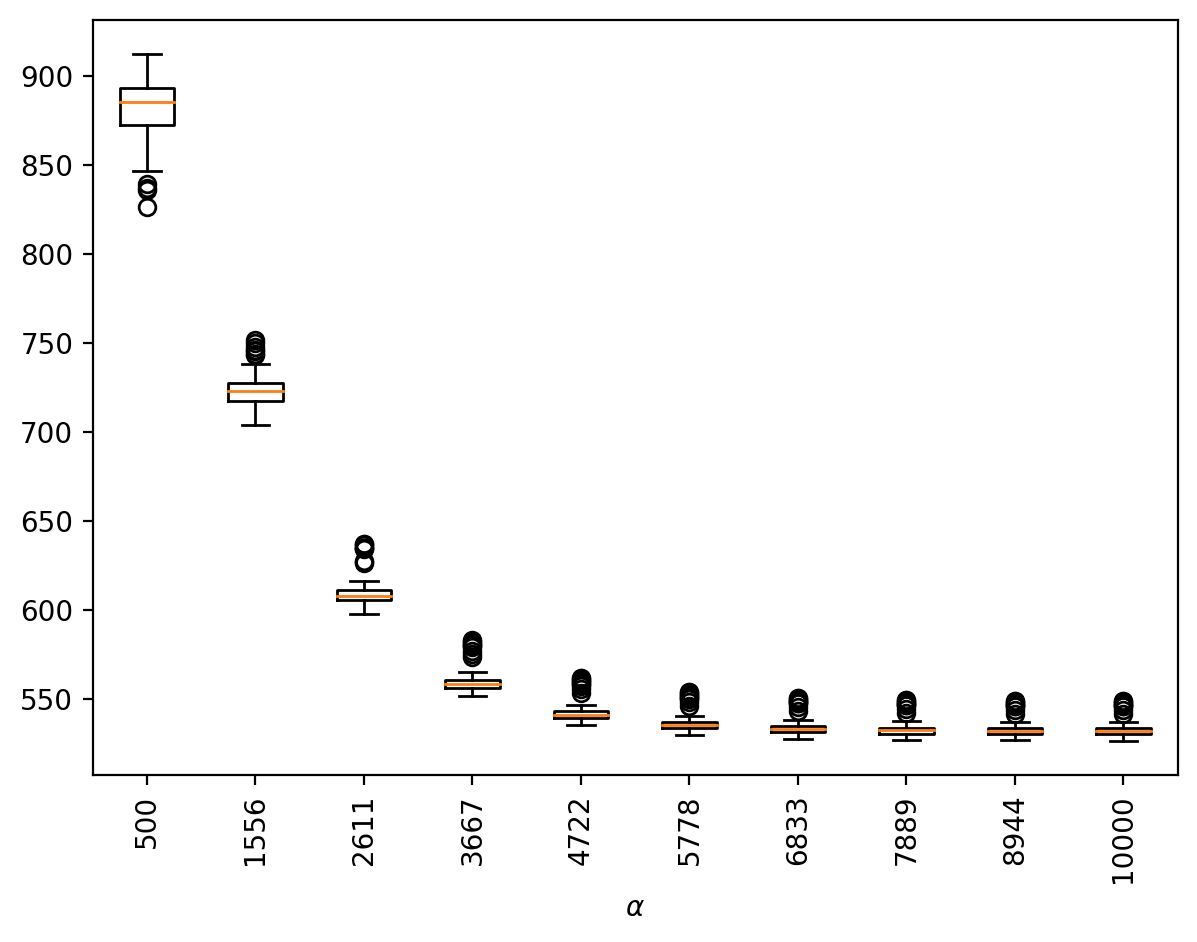

In [16]:
vals = [x[1].to_list() for x in mae_weighted]
labels = [int(x[0]) for x in mae_weighted]
labels = [round(x) for x in labels]
plt.figure(figsize=(7,5), dpi=200)
plt.boxplot(vals, labels=labels)
pos = range(1,len(vals)+1)
plt.xticks(pos, labels, rotation=90)
plt.xlabel(r"$\alpha$")
plt.savefig(saving_prefix + "_alpha_tuning_" + "_".join(included_methods) + ".png")

In [17]:
best_alpha = min(list(zip([x[1].median() for x in mae_weighted],labels)))[1]
print(best_alpha)
# del mae_weighted

10000


### Choose which metric we evaluate results with

In [18]:
error_fn = _mae

### Evaluate chosen best ensemble as candidate for weighted ensembles

In [19]:
eval_data = test

# Join weights
w_weights = pd.merge(eval_data, pd.DataFrame({"weight":weights["mae"][best_alpha]}), 
                                 how="left",
                                 left_on=["exp", "method"],
                                right_on=["exp", "method"])

# Get weighted ensemble predictions
w_weights["weighted_prediction"] = w_weights["prediction"]*w_weights["weight"]
weighted_ensemble = w_weights.groupby(["exp","id"]).agg({
'price' : 'mean',
'prediction' : 'mean',
'weighted_prediction' : 'sum', # This is where we apply ensembling scheme, weighting will add to 1
'method' : 'count',
})

# Get mean ensemble predictions
grouped = eval_data.groupby(["id", "exp"])
mean_ensemble = grouped.agg({
    'price' : 'mean',
    'prediction' : 'mean', # This is where we apply ensembling scheme
    'method' : 'count',
})

# Get error of weighted predictions
weighted_res = weighted_ensemble.groupby("exp").apply(lambda x: error_fn(x["price"], x["weighted_prediction"]))
mean_res = mean_ensemble.groupby("exp").apply(lambda x: error_fn(x["price"], x["prediction"]))
iso_res = eval_data.groupby(["exp","method"]).apply(lambda x: error_fn(x["price"], x["prediction"]) )

In [20]:
bars = ["Uniform ensemble", "Weighted ensemble" ,*iso_res.mean(level="method").keys()]
pos = range(len(bars))
height = [mean_res.mean(), weighted_res.mean(), *iso_res.mean(level="method").to_list()]
errs = [mean_res.std(), weighted_res.std(), *iso_res.std(level="method").to_list()]

[('Uniform ensemble', 1091.0419367341988, 9.853848600578145), ('Weighted ensemble', 909.7444058735263, 6.627226387850363), ('CNN', 2244.5368692116845, 29.1248450645408), ('GLM', 1093.1861941233128, 8.009424280691695), ('LM', 1145.025036150979, 8.366589568255083), ('NLP', 1747.677895253757, 13.15292216482537), ('NN', 1002.9931315350337, 11.56399961835742), ('RF', 909.7766880464067, 6.626827845902051)]


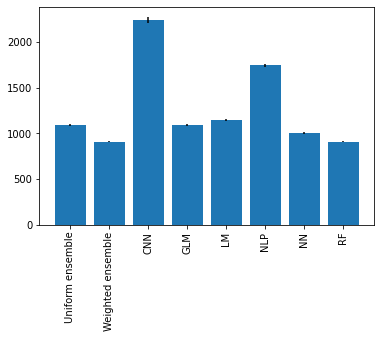

In [21]:
plt.bar(pos, height, yerr=errs)
plt.xticks(pos, bars, rotation=90)
res = list(zip(bars,height,errs))
print(res)
res_file = saving_prefix + "_means_" + "_".join(included_methods) + ".csv"
with open(res_file, "w") as f:
    for model_res in res:
        model_res = [str(x) for x in model_res]
        f.write(",".join(model_res)+"\n")

In [22]:
perc_improve = ((height[-1] - height[1])/height[-1])*100
with open(res_file, "a") as f:
    f.write(f"% improved, {perc_improve}\n")
perc_improve

0.0035483622854439924

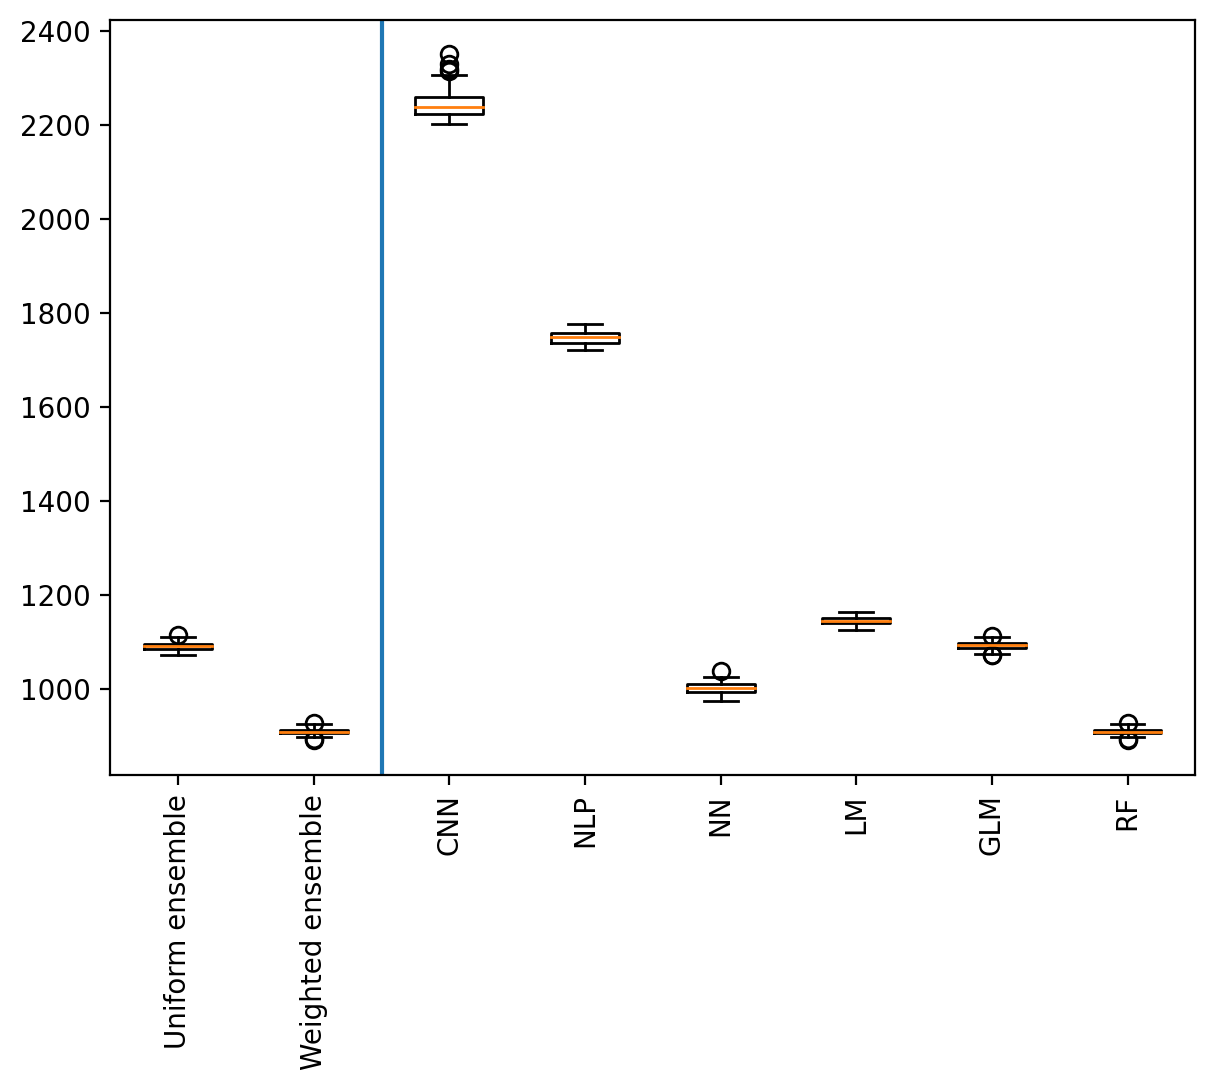

In [23]:
vals = [mean_res.to_list(), 
        weighted_res.to_list(), 
        *[iso_res.loc[:,method].to_list() for method in included_methods]]
labels = ["Uniform ensemble", "Weighted ensemble", *included_methods]

assert len(vals) == len(labels)

plt.figure(figsize=(7,5), dpi=200)
plt.boxplot(vals, labels=labels)
plt.axvline(2.5)
pos = range(1,len(vals)+1)
plt.xticks(pos, labels, rotation=90)
plt.savefig(saving_prefix + "_ensemble_comparison_" + "_".join(included_methods) + ".png")